<a href="https://colab.research.google.com/github/shrutikamokashi/EAI_Assignments/blob/master/Twitter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade

In [6]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 4
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
cd 'drive/My Drive/python'

[Errno 2] No such file or directory: 'drive/My Drive/python'
/content/drive/My Drive/python


In [55]:
df = pd.read_csv('EAI_Twitter_data.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df1 = pd.read_csv('EAI_Twitter_data2.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
df

,target,ids,date,flag,user,text
0,0.0,1.467810e+09,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0.0,1.467811e+09,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0.0,1.467811e+09,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0.0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0.0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1030268,NaN,NaN,NaN,NaN,NaN,NaN
1030269,NaN,NaN,NaN,NaN,NaN,NaN
1030270,NaN,NaN,NaN,NaN,NaN,NaN
1030271,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df1

,target,ids,date,flag,user,text
0,0,1972415508,Sat May 30 09:10:56 PDT 2009,NO_QUERY,xcactuskatex,Working all weekend
1,0,1972415691,Sat May 30 09:10:57 PDT 2009,NO_QUERY,annierabe,Its such a beautiful day and I'm stuck inside ...
2,0,1972415723,Sat May 30 09:10:57 PDT 2009,NO_QUERY,EricCHenry,Just now got up Eating bfast (butterscotch p...
3,0,1972415897,Sat May 30 09:10:58 PDT 2009,NO_QUERY,alyssaluvsmcfly,@tommcfly i wish that i could watch shows that...
4,0,1972415930,Sat May 30 09:10:58 PDT 2009,NO_QUERY,Haileythecooley,srry i haven't been on in a LONG time but i wi...
...,...,...,...,...,...,...
844945,4,1960186342,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Madelinedugganx,My GrandMa is making Dinenr with my Mum
844946,4,1960186409,Fri May 29 07:33:43 PDT 2009,NO_QUERY,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
844947,4,1960186429,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Falchion,@ShaDeLa same here say it like from the Termi...
844948,4,1960186445,Fri May 29 07:33:44 PDT 2009,NO_QUERY,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?


In [58]:
df = df.append(df1,ignore_index=True) 
df

,target,ids,date,flag,user,text
0,0.0,1.467810e+09,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0.0,1.467811e+09,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0.0,1.467811e+09,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0.0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0.0,1.467811e+09,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1875218,4.0,1.960186e+09,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Madelinedugganx,My GrandMa is making Dinenr with my Mum
1875219,4.0,1.960186e+09,Fri May 29 07:33:43 PDT 2009,NO_QUERY,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
1875220,4.0,1.960186e+09,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Falchion,@ShaDeLa same here say it like from the Termi...
1875221,4.0,1.960186e+09,Fri May 29 07:33:44 PDT 2009,NO_QUERY,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?


In [59]:
# 24 Duplicated entries
print('Total '+ str(df.duplicated().sum())+' Duplicate entries found!!')
df[df.duplicated()]

Total 826646 Duplicate entries found!!


,target,ids,date,flag,user,text
203627,NaN,NaN,NaN,NaN,NaN,NaN
203628,NaN,NaN,NaN,NaN,NaN,NaN
203629,NaN,NaN,NaN,NaN,NaN,NaN
203630,NaN,NaN,NaN,NaN,NaN,NaN
203631,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1030268,NaN,NaN,NaN,NaN,NaN,NaN
1030269,NaN,NaN,NaN,NaN,NaN,NaN
1030270,NaN,NaN,NaN,NaN,NaN,NaN
1030271,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#drops all the rows that have all the values as NaN    
for col in df.columns: 
    df = df[pd.notnull(df[col])]

df.drop_duplicates(inplace=True)

In [61]:
print("Dataset size:", len(df))
df.isnull().values.any()

Dataset size: 1048576


False

Map target label to String
0 -> NEGATIVE
2 -> NEUTRAL
4 -> POSITIVE

In [0]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [63]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 386 ms, sys: 13 ms, total: 399 ms
Wall time: 404 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

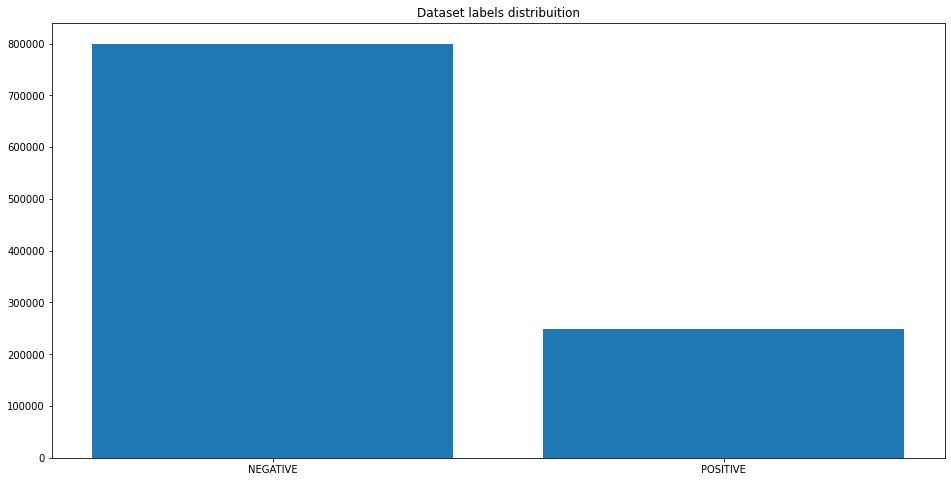

In [64]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [67]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 31.4 s, sys: 152 ms, total: 31.6 s
Wall time: 31.7 s


In [68]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 838860
TEST size: 209716


In [69]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 1.88 s, sys: 399 ms, total: 2.27 s
Wall time: 2.29 s


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [71]:
w2v_model.build_vocab(documents)

2020-03-23 09:28:11,192 : INFO : collecting all words and their counts
2020-03-23 09:28:11,194 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-23 09:28:11,221 : INFO : PROGRESS: at sentence #10000, processed 73104 words, keeping 13623 word types
2020-03-23 09:28:11,244 : INFO : PROGRESS: at sentence #20000, processed 146981 words, keeping 20993 word types
2020-03-23 09:28:11,269 : INFO : PROGRESS: at sentence #30000, processed 219193 words, keeping 26962 word types
2020-03-23 09:28:11,293 : INFO : PROGRESS: at sentence #40000, processed 292064 words, keeping 31950 word types
2020-03-23 09:28:11,319 : INFO : PROGRESS: at sentence #50000, processed 365698 words, keeping 36559 word types
2020-03-23 09:28:11,347 : INFO : PROGRESS: at sentence #60000, processed 439216 words, keeping 40946 word types
2020-03-23 09:28:11,372 : INFO : PROGRESS: at sentence #70000, processed 511927 words, keeping 44983 word types
2020-03-23 09:28:11,397 : INFO : PROGRESS: at s

In [72]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 23396


In [73]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-03-23 09:28:18,627 : INFO : training model with 8 workers on 23396 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-03-23 09:28:19,759 : INFO : EPOCH 1 - PROGRESS: at 5.87% examples, 284596 words/s, in_qsize 11, out_qsize 4
2020-03-23 09:28:20,859 : INFO : EPOCH 1 - PROGRESS: at 13.21% examples, 322392 words/s, in_qsize 15, out_qsize 3
2020-03-23 09:28:21,882 : INFO : EPOCH 1 - PROGRESS: at 20.09% examples, 336390 words/s, in_qsize 15, out_qsize 1
2020-03-23 09:28:22,984 : INFO : EPOCH 1 - PROGRESS: at 27.44% examples, 341842 words/s, in_qsize 15, out_qsize 0
2020-03-23 09:28:24,082 : INFO : EPOCH 1 - PROGRESS: at 34.14% examples, 339408 words/s, in_qsize 16, out_qsize 4
2020-03-23 09:28:25,107 : INFO : EPOCH 1 - PROGRESS: at 41.20% examples, 344331 words/s, in_qsize 15, out_qsize 0
2020-03-23 09:28:26,171 : INFO : EPOCH 1 - PROGRESS: at 47.72% examples, 342617 words/s, in_qsize 14, out_qsize 6
2020-03-23 09:28:27,265 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 15min 52s, sys: 4.32 s, total: 15min 57s
Wall time: 8min 9s


(172781435, 195546816)

In [74]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-03-23 09:36:28,113 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5598212480545044),
 ('loves', 0.53737473487854),
 ('loved', 0.4857100248336792),
 ('looove', 0.4743287265300751),
 ('amazing', 0.47102418541908264),
 ('adore', 0.4472741484642029),
 ('miss', 0.4463310241699219),
 ('loove', 0.4117814898490906),
 ('lov', 0.3926037549972534),
 ('awesome', 0.3886289596557617)]

In [75]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 210156
CPU times: user 15.4 s, sys: 136 ms, total: 15.5 s
Wall time: 15.5 s


In [76]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 21.1 s, sys: 644 ms, total: 21.8 s
Wall time: 21.8 s


In [77]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [78]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (838860, 1)
y_test (209716, 1)


In [79]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (838860, 300)
y_train (838860, 1)

x_test (209716, 300)
y_test (209716, 1)


In [80]:
y_train[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [81]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(210156, 300)


In [82]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

2020-03-23 09:37:06,783 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [83]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2020-03-23 09:37:06,813 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2020-03-23 09:37:06,827 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2020-03-23 09:37:06,844 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2020-03-23 09:37:06,846 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2020-03-23 09:37:06,848 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2020-03-23 09:37:06,974 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2020-03-23 09:37:06,977 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



2020-03-23 09:37:07,073 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2020-03-23 09:37:08,335 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2020-03-23 09:37:08,351 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          63046800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 63,207,301
Trainable params: 160,501
Non-trainable params: 63,046,800
_________________________________________________________________


In [84]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

2020-03-23 09:37:08,787 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



2020-03-23 09:37:08,821 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-03-23 09:37:08,830 : WARNING : From /tensorflow-1.15.0/python3.6/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [0]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=2,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2020-03-23 09:37:09,766 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2020-03-23 09:37:09,853 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 754974 samples, validate on 83886 samples
Epoch 1/2
372736/754974 [=============>................] - ETA: 1:01:26 - loss: 0.4386 - acc: 0.8008

In [0]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])